In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import hopsworks

In [10]:
# 1 -> external dataset, 2 -> local labelled data, 3 -> Hopsworks labelled data
USE_HOPSWORKS = True

if USE_HOPSWORKS:
    project = hopsworks.login()
    feature_store = project.get_feature_store()
    article_feature_group = feature_store.get_feature_group(name="training_data_stance", version=1)
    data = article_feature_group.read()
    data = data.rename(columns={'title': 'title', 'predicted_topic': 'subjects', 'stance': 'stance'})
    # as somehow Hopsworks ended up with NaNs at random rows, filter these rows
    data = data[data['stance'].notnull()]
    # convert from 1=neg, 2=neu, 3=pro to 0=neg, 1=neu, 2=pro
    data['stance'] = data['stance']-1
    data['stance'] = data['stance'].astype('category')
else:
    data = pd.read_csv('data/stance_data.csv')
    data = data.rename(columns={'post': 'title', 'new_topic': 'subjects', 'label': 'stance'})
    data['stance'] = data['stance'].astype('category')
    # convert from 0=neg, 1=pro, 2=neu to 0=neg, 1=neu, 2=pro
    neu = data['stance'] == 1
    data.loc[data['stance'] == 2, 'stance'] = 1
    data.loc[neu, 'stance'] = 2

display(data)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5270
Connected. Call `.close()` to terminate connection gracefully.
2022-12-29 11:43:13,498 INFO: USE `scalablemltask1_featurestore`
2022-12-29 11:43:13,961 INFO: SELECT `fg0`.`title` `title`, `fg0`.`saved_at` `saved_at`, `fg0`.`url` `url`, `fg0`.`stance` `stance`, `fg0`.`title_stance` `title_stance`, `fg0`.`title_topic` `title_topic`, `fg0`.`predicted_topic` `predicted_topic`
FROM `scalablemltask1_featurestore`.`training_data_stance_1` `fg0`


,title,saved_at,url,stance,title_stance,title_topic,subjects
1,"Stocks making the biggest moves midday: Netflix, Snap, Warner Bros. Discovery, AT&T, Novavax and more - CNBC",16/12/2022,https://www.cnbc.com/2022/12/15/stocks-making-the-biggest-moves-midday-netflix-snap-warner-bros-discovery-att-novavax-and-more-.html,1.0,stocks making the biggest moves midday netflix snap warner bros discovery at t novavax and more cnbc,stocks making biggest moves midday netflix snap warner bros discovery novavax cnbc,"cramer, market, cnbc"
2,Intel 13th Gen non-K CPUs are 28% to 64% faster than 12th Gen according to leaked tests - VideoCardz.com,15/12/2022,https://videocardz.com/newz/intel-13th-gen-non-k-cpus-are-28-to-64-faster-than-12th-gen-according-to-leaked-tests,2.0,intel 13th gen non k cpus are 28 to 64 faster than 12th gen according to leaked tests videocardz com,intel 13th gen non k cpus 28 64 faster 12th gen according leaked tests videocardz com,"videocardz, inch, macbook"
3,"Religion is not the factor that most influences rejection of evolutionary theory in schools, study says - Phys.org",15/12/2022,https://phys.org/news/2022-12-religion-factor-evolutionary-theory-schools.html,2.0,religion is not the factor that most influences rejection of evolutionary theory in schools study says phys org,religion factor influences rejection evolutionary theory schools study says phys org,"neuroscience, heart, help"
4,Let's a-go! Super Nintendo World sets Universal Studios opening date - The A.V. Club,15/12/2022,https://www.avclub.com/super-nintendo-world-universal-studios-hollywood-opens-1849893923,2.0,let s a go super nintendo world sets universal studios opening date the a v club,let go super nintendo world sets universal studios opening date v club,"nintendo, switch, life"
5,What parents should know about Covid vaccine boosters for kids age 5 and under - CNN,15/12/2022,https://www.cnn.com/2022/12/14/health/covid-bivalent-vaccine-young-children-wellness/index.html,1.0,what parents should know about covid vaccine boosters for kids age 5 and under cnn,parents know covid vaccine boosters kids age 5 cnn,"covid, vaccines, 19"
...,...,...,...,...,...,...,...
505,"Pope Francis says world suffering a ""famine of peace"" - BBC",25/12/2022,https://www.bbc.com/news/world-europe-64089428,0.0,pope francis says world suffering a famine of peace bbc,pope francis says world suffering famine peace bbc,"cup, africa, world"
506,"Chicago-area ComEd customers warned rolling power outages are possible Christmas Eve, Christmas Day - FOX 32 Chicago",25/12/2022,https://www.fox32chicago.com/news/chicago-area-comed-customers-warned-rolling-power-outages-are-possible-christmas-eve-christmas-day,0.0,chicago area comed customers warned rolling power outages are possible christmas eve christmas day fox 32 chicago,chicago area comed customers warned rolling power outages possible christmas eve christmas day fox 32 chicago,"storm, power, winter"
507,How Americans Really Feel About Elon Musk - FiveThirtyEight,23/12/2022,https://fivethirtyeight.com/features/how-americans-really-feel-about-elon-musk/,1.0,how americans really feel about elon musk fivethirtyeight,americans really feel elon musk fivethirtyeight,"twitter, musk, elon"
508,UN says 2022 is one of the worst years for Rohingya refugees - Al Jazeera English,27/12/2022,https://www.youtube.com/watch?v=b0Z21inyu8k,0.0,un says 2022 is one of the worst years for rohingya refugees al jazeera english,un says 2022 one worst years rohingya refugees al jazeera english,"cup, africa, world"


In [11]:
# data_train = data
X_train, X_test, y_train, y_test = train_test_split(data[['title', 'subjects']], data['stance'], test_size=0.33)

pd.set_option('display.max_colwidth', None)
display(data)
print(data.dtypes)

display(X_train)

,title,saved_at,url,stance,title_stance,title_topic,subjects
1,"Stocks making the biggest moves midday: Netflix, Snap, Warner Bros. Discovery, AT&T, Novavax and more - CNBC",16/12/2022,https://www.cnbc.com/2022/12/15/stocks-making-the-biggest-moves-midday-netflix-snap-warner-bros-discovery-att-novavax-and-more-.html,1.0,stocks making the biggest moves midday netflix snap warner bros discovery at t novavax and more cnbc,stocks making biggest moves midday netflix snap warner bros discovery novavax cnbc,"cramer, market, cnbc"
2,Intel 13th Gen non-K CPUs are 28% to 64% faster than 12th Gen according to leaked tests - VideoCardz.com,15/12/2022,https://videocardz.com/newz/intel-13th-gen-non-k-cpus-are-28-to-64-faster-than-12th-gen-according-to-leaked-tests,2.0,intel 13th gen non k cpus are 28 to 64 faster than 12th gen according to leaked tests videocardz com,intel 13th gen non k cpus 28 64 faster 12th gen according leaked tests videocardz com,"videocardz, inch, macbook"
3,"Religion is not the factor that most influences rejection of evolutionary theory in schools, study says - Phys.org",15/12/2022,https://phys.org/news/2022-12-religion-factor-evolutionary-theory-schools.html,2.0,religion is not the factor that most influences rejection of evolutionary theory in schools study says phys org,religion factor influences rejection evolutionary theory schools study says phys org,"neuroscience, heart, help"
4,Let's a-go! Super Nintendo World sets Universal Studios opening date - The A.V. Club,15/12/2022,https://www.avclub.com/super-nintendo-world-universal-studios-hollywood-opens-1849893923,2.0,let s a go super nintendo world sets universal studios opening date the a v club,let go super nintendo world sets universal studios opening date v club,"nintendo, switch, life"
5,What parents should know about Covid vaccine boosters for kids age 5 and under - CNN,15/12/2022,https://www.cnn.com/2022/12/14/health/covid-bivalent-vaccine-young-children-wellness/index.html,1.0,what parents should know about covid vaccine boosters for kids age 5 and under cnn,parents know covid vaccine boosters kids age 5 cnn,"covid, vaccines, 19"
...,...,...,...,...,...,...,...
505,"Pope Francis says world suffering a ""famine of peace"" - BBC",25/12/2022,https://www.bbc.com/news/world-europe-64089428,0.0,pope francis says world suffering a famine of peace bbc,pope francis says world suffering famine peace bbc,"cup, africa, world"
506,"Chicago-area ComEd customers warned rolling power outages are possible Christmas Eve, Christmas Day - FOX 32 Chicago",25/12/2022,https://www.fox32chicago.com/news/chicago-area-comed-customers-warned-rolling-power-outages-are-possible-christmas-eve-christmas-day,0.0,chicago area comed customers warned rolling power outages are possible christmas eve christmas day fox 32 chicago,chicago area comed customers warned rolling power outages possible christmas eve christmas day fox 32 chicago,"storm, power, winter"
507,How Americans Really Feel About Elon Musk - FiveThirtyEight,23/12/2022,https://fivethirtyeight.com/features/how-americans-really-feel-about-elon-musk/,1.0,how americans really feel about elon musk fivethirtyeight,americans really feel elon musk fivethirtyeight,"twitter, musk, elon"
508,UN says 2022 is one of the worst years for Rohingya refugees - Al Jazeera English,27/12/2022,https://www.youtube.com/watch?v=b0Z21inyu8k,0.0,un says 2022 is one of the worst years for rohingya refugees al jazeera english,un says 2022 one worst years rohingya refugees al jazeera english,"cup, africa, world"


title             object
saved_at          object
url               object
stance          category
title_stance      object
title_topic       object
subjects          object
dtype: object


,title,subjects
42,Moving on From Melatonin? This Dietary Supplement Can Also Help You Sleep - CNET,"neuroscience, heart, help"
128,Taco Bell may add fries to its menu permanently to compete with McDonald's - CNN,"twitter, musk, elon"
320,New Study Links COVID-19 Vaccination Status to Increased Risk of Car Crashes - Jalopnik,"covid, vaccines, 19"
103,Aaron Dean found guilty of manslaughter in 2019 killing of Atatiana Jefferson - CBS News,"shooting, paris, kurds"
494,Paris shooting: Protests after deadly attack on Kurds - BBC,"shooting, paris, kurds"
...,...,...
149,2 children died from severe strep since November amid rise in hospitalizations - 9NEWS,"strep, children, died"
115,"TikTok may push potentially harmful content to teens within minutes, study finds - CNN","chatgpt, tiktok, ban"
138,House passes bill to replace bust of Roger Taney with one honoring Thurgood Marshall - CNN,"bill, crypto, scheme"
328,"Free Gran Turismo 7 Update 1.27 Adds Five Cars to PS5, PS4 and Norwegian Scapes - Push Square","kotaku, update, xbox"


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 subjects (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['title[0][0]',                  
                                (None, 128),                      'subjects[0][0]']               
                                 'input_type_ids':                                                
                                (None, 128),                                                

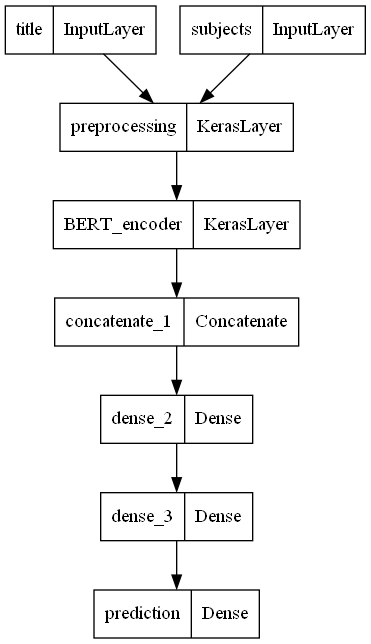

In [12]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
hidden_layer_sizes = [300, 100]
alpha_leaky_relu = 0.01
dropout = 0
number_of_output_classes = 3

def build_classifier_model():
    # Handle categorical labels
    # encoded_stance = get_category_encoding_layer(name='categorical', dataset=data_train, dtype='string')

    # BERT embeddings
    preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

    title = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')
    titles_preprocessed = preprocessor(title)

    subjects = tf.keras.layers.Input(shape=(), dtype=tf.string, name='subjects')
    subjects_preprocessed = preprocessor(subjects)

    # pooled_output gives the embedding per input sequence, alternatively sequence_output would give it per input token
    titles_embedded = encoder(titles_preprocessed)["pooled_output"]
    subjects_embedded = encoder(subjects_preprocessed)["pooled_output"]

    # Concat features
    # titles_embedded = tf.keras.layers.Flatten()(titles_embedded)
    # subjects_embedded = tf.keras.layers.Flatten()(subjects_embedded)
    concatenated_features = tf.keras.layers.Concatenate()([titles_embedded, subjects_embedded])
    out = concatenated_features

    # Neural network hidden layers
    for number_of_hidden_units in hidden_layer_sizes:
        out = tf.keras.layers.Dense(number_of_hidden_units, activation=tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))(out)
        if dropout > 0:
            out = tf.keras.layers.Dropout(dropout)(out)

    # Output
    out = tf.keras.layers.Dense(number_of_output_classes, activation=tf.nn.softmax, name='prediction')(out)

    return tf.keras.Model(
        inputs = [title, subjects],
        outputs = out
    )

# In case of "SavedModel file does not exist at:" error, go the Temp\tfhub_modules folder it references and delete it
model = build_classifier_model()
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
# steps_per_epoch = tf.data.experimental.cardinality(data_train).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)
#
# init_lr = 3e-5
# optimizer = tf.keras.optimizers.create_optimizer( init_lr=init_lr,
#                                                   num_train_steps=num_train_steps,
#                                                   num_warmup_steps=num_warmup_steps,
#                                                   optimizer_type='adamw')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

epochs=5
history = model.fit(
    x=[
        X_train['title'],
        X_train['subjects']
    ],
    y=y_train,
    epochs=epochs,
    validation_data=([X_test['title'], X_test['subjects']], y_test)
)


Epoch 1/5
11/11 [==============================] - 86s 8s/step - loss: 1.1370 - accuracy: 0.3951 - val_loss: 1.1227 - val_accuracy: 0.4110
Epoch 2/5
 7/11 [==================>...........] - ETA: 26s - loss: 1.0921 - accuracy: 0.4152

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("/models/stance_model_v4")

In [ ]:
from tensorflow import keras

# load model
# model = keras.models.load_model("/models/stance_model_v1")